In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dota-2-matches-pro-leagues/dota2_versions.csv
/kaggle/input/dota-2-matches-pro-leagues/dota2_matches_PREVIEW.csv
/kaggle/input/dota-2-matches-pro-leagues/dota2_matches.parquet


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [3]:
dir_path = '../input/dota-2-matches-pro-leagues/'
matches_path = dir_path + 'dota2_matches.parquet'
versions_path = dir_path + 'dota2_versions.csv'

In [4]:
matches = pd.read_parquet(matches_path, engine='pyarrow')

In [5]:
THRESHOLD_DATE = '2024-01-01'
matches = matches[matches.match_start_date_time < THRESHOLD_DATE]
matches

,league,league_id,league_tier,league_start_date_time,league_end_date_time,league_region,series_id,series_type,match_id,match_start_date_time,...,dire_player_5_hero_id,dire_player_5_hero,dire_player_5_position,dire_player_5_lane,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,game_version_id
9059,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515605198,2023-12-31 23:36:35,...,109,Terrorblade,POSITION_1,SAFE_LANE,CORE,2,4,5,16288,170
9060,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515575705,2023-12-31 22:52:28,...,69,Doom,POSITION_3,OFF_LANE,CORE,5,8,18,12976,170
9061,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515557910,2023-12-31 22:27:49,...,69,Doom,POSITION_4,OFF_LANE,LIGHT_SUPPORT,5,3,18,15148,170
9062,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515528762,2023-12-31 21:47:39,...,46,Templar Assassin,POSITION_1,SAFE_LANE,CORE,8,6,4,26130,170
9063,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515510207,2023-12-31 21:23:26,...,31,Lich,POSITION_5,SAFE_LANE,HARD_SUPPORT,5,10,17,20447,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177373,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002746,BEST_OF_ONE,7472,2011-08-02 00:00:00,...,58,Enchantress,<NA>,<NA>,<NA>,14,3,13,11513,11
177374,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002747,BEST_OF_ONE,4464,2011-06-26 00:00:00,...,35,Sniper,<NA>,<NA>,<NA>,6,4,8,4555,8
177375,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002748,BEST_OF_ONE,4081,2011-06-20 00:00:00,...,15,Razor,<NA>,<NA>,<NA>,4,7,1,6145,8
177376,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002749,BEST_OF_ONE,4067,2011-06-19 00:00:00,...,29,Tidehunter,<NA>,<NA>,<NA>,7,3,14,11637,8


## Missing Values

In [6]:
winner_na = matches.winner_id.isna()
radiant_na = matches.radiant_team_id.isna()
dire_na = matches.dire_team_id.isna()

len_init = len(matches)

matches = matches[~(winner_na | radiant_na | dire_na)].copy()
print(f'Missing values: {(len_init - len(matches)) / len_init * 100:.2f}%')

Missing values: 1.03%


In [7]:
print(f'Missing values of the whole dataframe: {matches.isna().sum().sum()}')
print(f'Fraction of missed values: {matches.isna().sum().sum() / (matches.shape[0] * matches.shape[1])}')
print(f'Fraction of matches that have at least 1 missing value: {(matches.isna().sum(1) > 0).mean()}')

Missing values of the whole dataframe: 2180460
Fraction of missed values: 0.10068474269162198
Fraction of matches that have at least 1 missing value: 0.7278299026934875


In [8]:
matches['year_month'] = matches.match_start_date_time.dt.to_period('M')

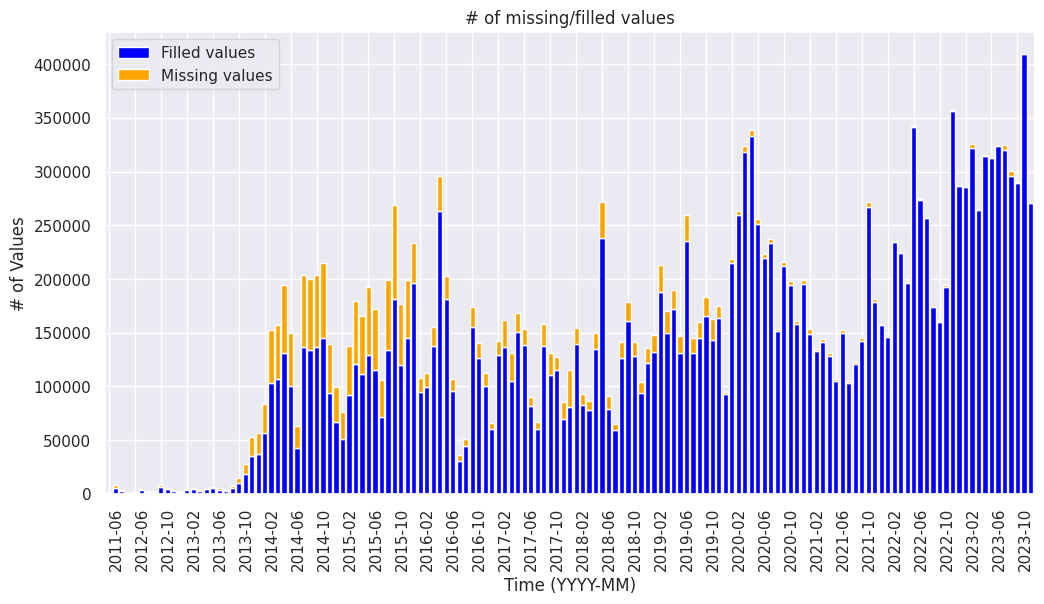

In [9]:
monthly_valid_values = (~matches.isna()).groupby(matches.year_month).sum().sum(1)
monthly_missing_values = matches.isna().groupby(matches['year_month']).sum().sum(1)

plt.figure(figsize=(12, 6))

valid_label = 'Filled values'
missing_label = 'Missing values'
monthly_valid_values.plot(kind='bar', width=0.8, color='blue', label=valid_label)
monthly_missing_values.plot(kind='bar', bottom=monthly_valid_values, width=0.8,
                            color='orange', label=missing_label)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('# of Values')
plt.title('# of missing/filled values')
plt.legend()

xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks[::4])
plt.gca().set_xticklabels(monthly_missing_values.index[::4].strftime('%Y-%m'), rotation=90, ha='left')

plt.show()

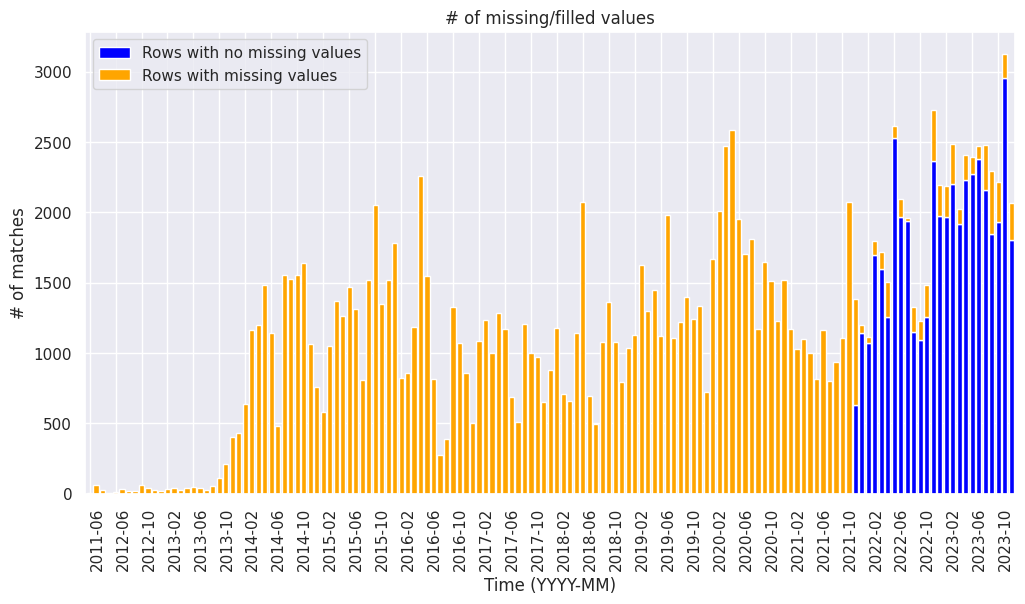

In [10]:
all_rows_per_month = matches.groupby('year_month').size()
corrupted_rows_per_month = matches[matches.isna().sum(1) > 0].groupby('year_month').size()
corrupted_rows_per_month = corrupted_rows_per_month.reindex(all_rows_per_month.index, fill_value=0)
complete_rows_per_month = all_rows_per_month.sub(corrupted_rows_per_month, fill_value=0)

complete_label = 'Rows with no missing values'
corrupted_label = 'Rows with missing values'

plt.figure(figsize=(12, 6))
complete_rows_per_month.plot(kind='bar', width=0.8, color='blue', label=complete_label)
corrupted_rows_per_month.plot(kind='bar', bottom=complete_rows_per_month, width=0.8,
                             color='orange', label=corrupted_label)

plt.xlabel('Time (YYYY-MM)')
plt.ylabel('# of matches')
plt.title('# of missing/filled values')
plt.legend()

xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks[::4])
plt.gca().set_xticklabels(monthly_missing_values.index[::4].strftime('%Y-%m'), rotation=90, ha='left')

plt.show()


In [11]:
print('Features that do not have any missing values:')
matches.columns[matches.isna().sum(0) == 0].tolist()

Features that do not have any missing values:


['league',
 'league_id',
 'league_tier',
 'series_id',
 'series_type',
 'match_id',
 'match_start_date_time',
 'match_duration_seconds',
 'radiant_team_id',
 'dire_team_id',
 'winner_id',
 'radiant_player_1_hero_id',
 'radiant_player_1_kills',
 'radiant_player_1_deaths',
 'radiant_player_1_assists',
 'year_month']

In [12]:
matches.columns[matches[matches.match_start_date_time < '2021-01-01'].isna().mean() == 1]

Index(['radiant_kills', 'dire_kills'], dtype='object')

In [13]:
radiant_kills_feats = [f'radiant_player_{i}_kills' for i in range(1, 6)]
matches['radiant_kills'] = matches[radiant_kills_feats].sum(1)
dire_kills_feats = [f'dire_player_{i}_kills' for i in range(1, 6)]
matches['dire_kills'] = matches[dire_kills_feats].sum(1)
matches['total_kills'] = matches.radiant_kills + matches.dire_kills

In [14]:
matches['total_kills']

9059       55
9060       59
9061       43
9062       57
9063       68
         ... 
177373     66
177374    101
177375     44
177376     60
177377     67
Name: total_kills, Length: 166587, dtype: int16[pyarrow]

## Match duration

In [15]:
matches['match_duration_minutes'] = matches.match_duration_seconds / 60
matches.match_duration_minutes.describe()

count     166587.0
mean     34.469709
std      11.289517
min            0.0
25%      26.766667
50%          33.15
75%      40.933333
max         289.45
Name: match_duration_minutes, dtype: double[pyarrow]

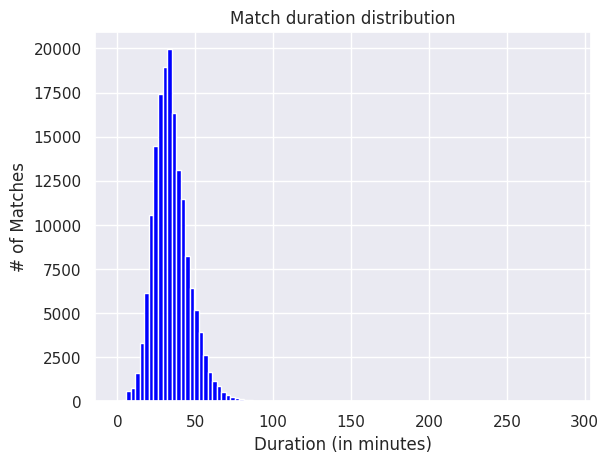

In [16]:
plt.hist(matches.match_duration_minutes, bins=100, color='blue')

plt.title('Match duration distribution')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches')
plt.show()

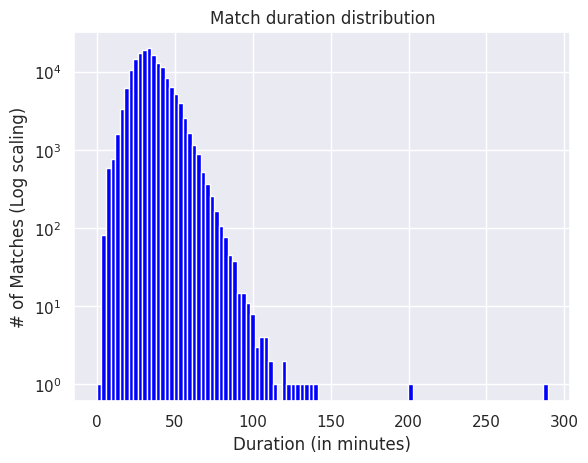

In [17]:
plt.hist(matches.match_duration_minutes, bins=100, color='blue')

plt.title('Match duration distribution')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches (Log scaling)')
plt.yscale('log')
plt.show()

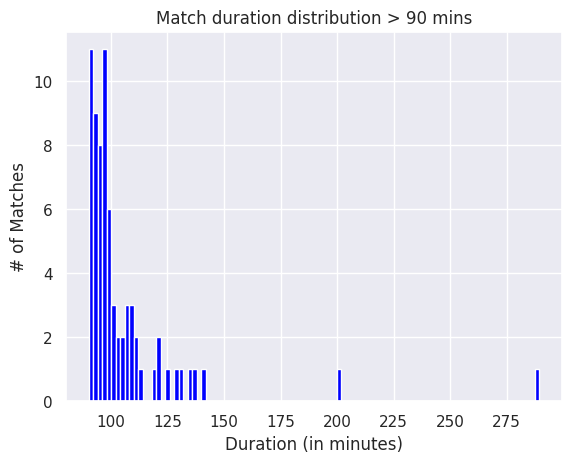

In [18]:
plt.hist(matches[matches.match_duration_minutes >= 90].match_duration_minutes,
         bins=100, color='blue')

plt.title('Match duration distribution > 90 mins')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches')
plt.show()

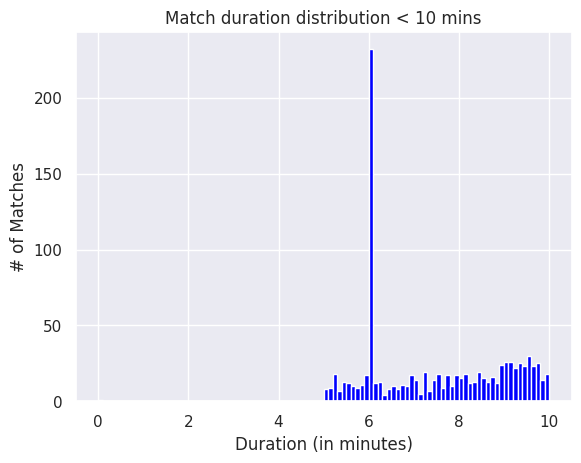

In [19]:
plt.hist(matches[matches.match_duration_minutes <= 10].match_duration_minutes,
         bins=100, color='blue')

plt.title('Match duration distribution < 10 mins')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches')
plt.show()

In [20]:
print("Anomaly detected")
print(matches[matches.match_duration_minutes <= 10].match_duration_minutes.value_counts())


Anomaly detected
match_duration_minutes
6.0         212
9.133333     10
8.45          7
9.366667      7
9.016667      7
           ... 
6.066667      1
5.85          1
9.2           1
7.633333      1
9.9           1
Name: count, Length: 266, dtype: int64[pyarrow]


In [21]:
matches['radiant_win'] = (matches.winner_id == matches.radiant_team_id)
matches_6_mins = matches[matches.match_duration_minutes == 6]

print(f'Radiant win rate for 6-min long matches : {round(matches_6_mins.radiant_win.mean()*100,2)} %')
print(f'Radiant win rate for all matches : {round(matches.radiant_win.mean()*100,2)} %')

Radiant win rate for 6-min long matches : 4.72 %
Radiant win rate for all matches : 51.19 %


## Net Worth vs Duration

In [22]:

common_features = [col for col in matches.columns if not any(col.startswith(prefix) for prefix in ['radiant_player_', 'dire_player_'])]


player_dfs = []


for i in range(1, 6):
    for team in ['radiant', 'dire']:

        player_cols = [col for col in matches.columns if col.startswith(f"{team}_player_{i}_")]

        selected_columns = common_features + player_cols

        temp_df = matches[selected_columns].copy()

        temp_df.columns = [col.replace(f"{team}_player_{i}_", '') if col.startswith(f"{team}_player_{i}_") else col for col in temp_df.columns]

        temp_df['team'] = team

        temp_df['position'] = temp_df.position.apply(lambda s: int(s[-1]) if pd.notna(s) and s != '' else pd.NA)
        temp_df['win'] = temp_df.radiant_win if team == 'radiant' else ~temp_df.radiant_win
        temp_df['win'] = temp_df.win.astype(bool)

        player_dfs.append(temp_df)


players = pd.concat(player_dfs, ignore_index=True)

players

,league,league_id,league_tier,league_start_date_time,league_end_date_time,league_region,series_id,series_type,match_id,match_start_date_time,...,hero,position,lane,role,kills,deaths,assists,networth,team,win
0,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515605198,2023-12-31 23:36:35,...,Mars,3,OFF_LANE,CORE,10,3,16,17351,radiant,True
1,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515575705,2023-12-31 22:52:28,...,Earthshaker,2,MID_LANE,CORE,8,7,3,16367,radiant,False
2,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515557910,2023-12-31 22:27:49,...,Terrorblade,1,SAFE_LANE,CORE,0,5,6,15392,radiant,False
3,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515528762,2023-12-31 21:47:39,...,Razor,2,MID_LANE,CORE,5,5,6,25269,radiant,False
4,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515510207,2023-12-31 21:23:26,...,Luna,1,SAFE_LANE,CORE,3,7,8,25924,radiant,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665865,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002746,BEST_OF_ONE,7472,2011-08-02 00:00:00,...,Enchantress,<NA>,<NA>,<NA>,14,3,13,11513,dire,True
1665866,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002747,BEST_OF_ONE,4464,2011-06-26 00:00:00,...,Sniper,<NA>,<NA>,<NA>,6,4,8,4555,dire,True
1665867,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002748,BEST_OF_ONE,4081,2011-06-20 00:00:00,...,Razor,<NA>,<NA>,<NA>,4,7,1,6145,dire,False
1665868,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002749,BEST_OF_ONE,4067,2011-06-19 00:00:00,...,Tidehunter,<NA>,<NA>,<NA>,7,3,14,11637,dire,True


In [23]:
[col for col in
matches.columns[matches[matches.match_start_date_time >= '2020-01-01'].isna().sum(0) == 0]
if col.endswith('networth')
]

['radiant_player_1_networth',
 'radiant_player_2_networth',
 'radiant_player_3_networth',
 'radiant_player_4_networth',
 'radiant_player_5_networth',
 'dire_player_1_networth',
 'dire_player_2_networth',
 'dire_player_3_networth',
 'dire_player_4_networth',
 'dire_player_5_networth']

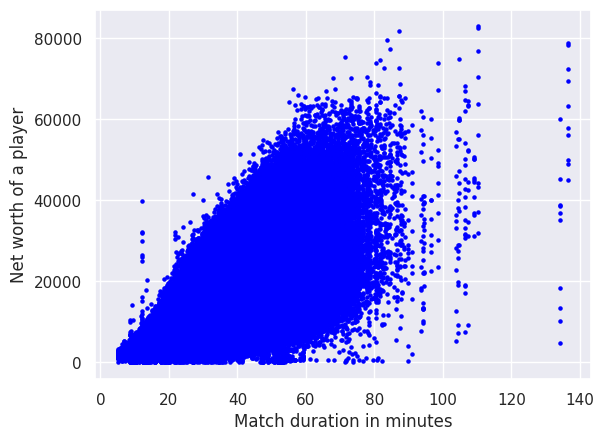

In [24]:
plt.scatter(players.match_duration_minutes, players.networth, color='blue',
           s=5)

plt.xlabel('Match duration in minutes')
plt.ylabel('Net worth of a player')
plt.show()

#### Too dense, we need a subset

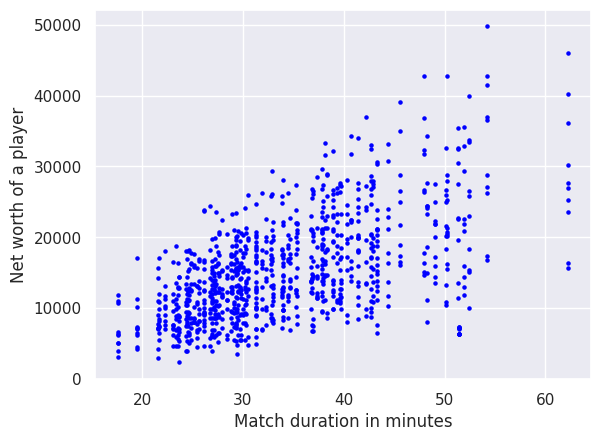

In [25]:
players_subset = players[players.match_start_date_time >= '2023-12-30']
plt.scatter(players_subset.match_duration_minutes,players_subset.networth, color='blue',
           s=5)

plt.xlabel('Match duration in minutes')
plt.ylabel('Net worth of a player')
plt.show()

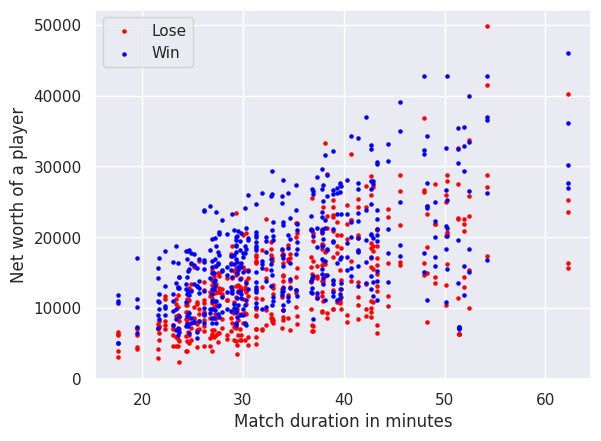

In [26]:
colors = {True: 'blue', False: 'red'}
labels = {True: 'Win', False: 'Lose'}

for status, data in players_subset.groupby('win'):
    plt.scatter(data.match_duration_minutes, data.networth,
               color=colors[status], label=labels[status], s=5)

plt.xlabel('Match duration in minutes')
plt.ylabel('Net worth of a player')
plt.legend()

plt.show()

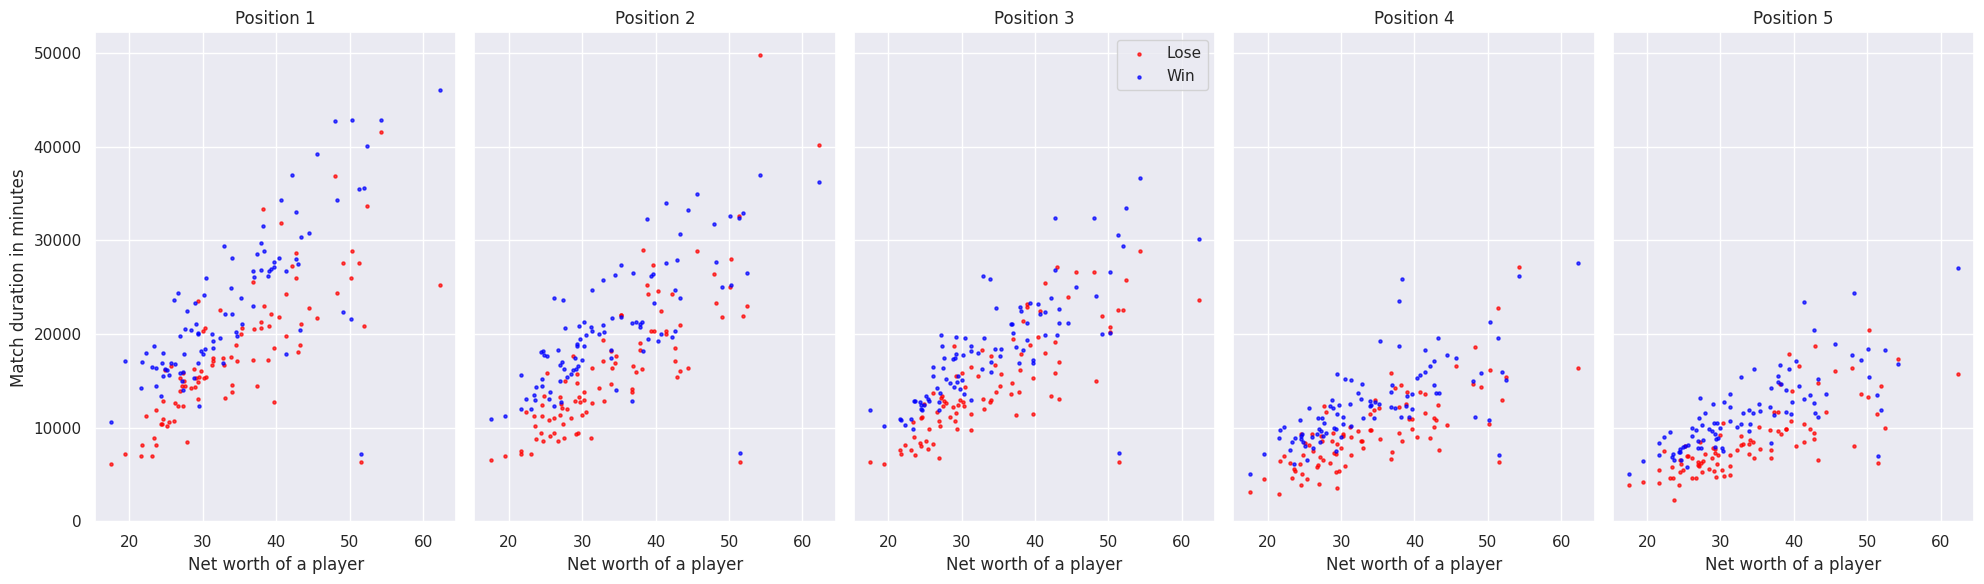

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(20, 6), sharey=True)  
colors_win_lose = {True: 'blue', False: 'red'}  

for position in range(1, 6):
    ax = axs[position-1]
    for win, data in players_subset[players_subset['position'] == position].groupby('win'):
        ax.scatter(data.match_duration_minutes, data.networth,
                   color=colors_win_lose[win], label=f'{"Win" if win else "Lose"}', s=5, alpha=0.7)
    ax.set_title(f'Position {position}')
    if position == 1:
        ax.set_ylabel('Match duration in minutes')
    ax.set_xlabel('Net worth of a player')
    if position == 3:  
        ax.legend()

plt.tight_layout()
plt.show()

## Feature Encoding

In [28]:
missing_values_count = matches.isna().sum()
features_with_most_missing_values = missing_values_count.sort_values(ascending=False)
features_with_most_missing_values

radiant_player_2_networth    80374
radiant_player_3_networth    80374
dire_player_3_networth       80374
radiant_player_1_networth    80374
radiant_player_4_networth    80374
                             ...  
dire_kills                       0
radiant_player_1_hero_id         0
radiant_player_1_kills           0
radiant_player_1_deaths          0
radiant_win                      0
Length: 134, dtype: int64

In [29]:
matches = matches.dropna()
matches

,league,league_id,league_tier,league_start_date_time,league_end_date_time,league_region,series_id,series_type,match_id,match_start_date_time,...,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,game_version_id,year_month,total_kills,match_duration_minutes,radiant_win
9059,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515605198,2023-12-31 23:36:35,...,CORE,2,4,5,16288,170,2023-12,55,28.783333,True
9060,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515575705,2023-12-31 22:52:28,...,CORE,5,8,18,12976,170,2023-12,59,31.333333,False
9061,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515557910,2023-12-31 22:27:49,...,LIGHT_SUPPORT,5,3,18,15148,170,2023-12,43,30.483333,False
9062,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515528762,2023-12-31 21:47:39,...,CORE,8,6,4,26130,170,2023-12,57,38.883333,False
9063,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515510207,2023-12-31 21:23:26,...,HARD_SUPPORT,5,10,17,20447,170,2023-12,68,42.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112868,Russian Pro League,8069,PROFESSIONAL,2018-06-04 00:00:00,2018-06-30 00:00:00,CIS,246056,BEST_OF_THREE,4129856028,2018-09-21 00:00:00,...,CORE,1,7,7,3392,99,2018-09,60,27.85,True
113327,DOTA 2 INDONESIA ONLINE TOURNEY by Maxmund 8,9578,PROFESSIONAL,2018-06-06 00:00:00,2018-06-10 00:00:00,SEA,101534646,BEST_OF_ONE,4117124436,2018-09-14 00:00:00,...,CORE,5,0,4,9018,99,2018-09,27,18.616667,False
117380,ESL India Premiership - 2017 Edition,5407,PROFESSIONAL,2017-05-10 00:00:00,2017-12-22 00:00:00,SEA,101532648,BEST_OF_ONE,3901011325,2018-05-19 00:00:00,...,CORE,7,13,9,10303,92,2018-05,81,36.4,True
117749,NON STOP Energy League,9971,PROFESSIONAL,2018-05-12 00:00:00,2018-06-24 00:00:00,EUROPE,101532596,BEST_OF_ONE,3887809621,2018-05-13 00:00:00,...,HARD_SUPPORT,1,8,3,3778,92,2018-05,37,12.183333,True


In [30]:
from collections import defaultdict
empty_strs = defaultdict(int)
for column in matches.columns:
    if matches[column].dtype == 'string[pyarrow]' and '' in matches[column].unique():
        empty_strs[column]+=1
    
print(f"Columns that have empty string '' : {empty_strs.keys()}")

Columns that have empty string '' : dict_keys(['radiant_team_name', 'dire_team_name', 'radiant_player_1_position', 'radiant_player_1_lane', 'radiant_player_1_role', 'radiant_player_2_position', 'radiant_player_2_lane', 'radiant_player_2_role', 'radiant_player_3_position', 'radiant_player_3_lane', 'radiant_player_3_role', 'radiant_player_4_position', 'radiant_player_4_lane', 'radiant_player_4_role', 'radiant_player_5_position', 'radiant_player_5_lane', 'radiant_player_5_role', 'dire_player_1_position', 'dire_player_1_lane', 'dire_player_1_role', 'dire_player_2_position', 'dire_player_2_lane', 'dire_player_2_role', 'dire_player_3_position', 'dire_player_3_lane', 'dire_player_3_role', 'dire_player_4_position', 'dire_player_4_lane', 'dire_player_4_role', 'dire_player_5_position', 'dire_player_5_lane', 'dire_player_5_role'])


In [31]:
matches = matches[matches != ''].dropna()
matches

,league,league_id,league_tier,league_start_date_time,league_end_date_time,league_region,series_id,series_type,match_id,match_start_date_time,...,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,game_version_id,year_month,total_kills,match_duration_minutes,radiant_win
9059,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515605198,2023-12-31 23:36:35,...,CORE,2,4,5,16288,170,2023-12,55,28.783333,True
9060,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515575705,2023-12-31 22:52:28,...,CORE,5,8,18,12976,170,2023-12,59,31.333333,False
9061,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515557910,2023-12-31 22:27:49,...,LIGHT_SUPPORT,5,3,18,15148,170,2023-12,43,30.483333,False
9062,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515528762,2023-12-31 21:47:39,...,CORE,8,6,4,26130,170,2023-12,57,38.883333,False
9063,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515510207,2023-12-31 21:23:26,...,HARD_SUPPORT,5,10,17,20447,170,2023-12,68,42.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112868,Russian Pro League,8069,PROFESSIONAL,2018-06-04 00:00:00,2018-06-30 00:00:00,CIS,246056,BEST_OF_THREE,4129856028,2018-09-21 00:00:00,...,CORE,1,7,7,3392,99,2018-09,60,27.85,True
113327,DOTA 2 INDONESIA ONLINE TOURNEY by Maxmund 8,9578,PROFESSIONAL,2018-06-06 00:00:00,2018-06-10 00:00:00,SEA,101534646,BEST_OF_ONE,4117124436,2018-09-14 00:00:00,...,CORE,5,0,4,9018,99,2018-09,27,18.616667,False
117380,ESL India Premiership - 2017 Edition,5407,PROFESSIONAL,2017-05-10 00:00:00,2017-12-22 00:00:00,SEA,101532648,BEST_OF_ONE,3901011325,2018-05-19 00:00:00,...,CORE,7,13,9,10303,92,2018-05,81,36.4,True
117749,NON STOP Energy League,9971,PROFESSIONAL,2018-05-12 00:00:00,2018-06-24 00:00:00,EUROPE,101532596,BEST_OF_ONE,3887809621,2018-05-13 00:00:00,...,HARD_SUPPORT,1,8,3,3778,92,2018-05,37,12.183333,True


In [32]:
columns_to_drop = ['league', 'league_tier', 'league_region', 'series_type', 'radiant_team_name','dire_team_name','game_version_id',
                   'year_month','league_id','league_start_date_time','league_end_date_time','series_id', 'match_id','match_start_date_time','radiant_team_id','dire_team_id',
                  'winner_id','match_duration_seconds']
player_features = [col for col in matches.columns if not any(col.startswith(prefix) for prefix in ['radiant_player_', 'dire_player_'])]

for i in range(1, 6):
    for team in ['radiant', 'dire']:
        for suffix in ['name','id','hero','lane']:
            col_str = f"{team}_player_{i}_{suffix}"
            columns_to_drop.append(col_str)

df = matches.drop(columns=columns_to_drop)
df

,first_blood_time_seconds,radiant_kills,dire_kills,radiant_player_1_hero_id,radiant_player_1_position,radiant_player_1_role,radiant_player_1_kills,radiant_player_1_deaths,radiant_player_1_assists,radiant_player_1_networth,...,dire_player_5_hero_id,dire_player_5_position,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,total_kills,match_duration_minutes,radiant_win
9059,89,34,21,129,POSITION_3,CORE,10,3,16,17351,...,109,POSITION_1,CORE,2,4,5,16288,55,28.783333,True
9060,131,23,36,7,POSITION_2,CORE,8,7,3,16367,...,69,POSITION_3,CORE,5,8,18,12976,59,31.333333,False
9061,145,12,31,109,POSITION_1,CORE,0,5,6,15392,...,69,POSITION_4,LIGHT_SUPPORT,5,3,18,15148,43,30.483333,False
9062,248,29,28,15,POSITION_2,CORE,5,5,6,25269,...,46,POSITION_1,CORE,8,6,4,26130,57,38.883333,False
9063,148,28,40,48,POSITION_1,CORE,3,7,8,25924,...,31,POSITION_5,HARD_SUPPORT,5,10,17,20447,68,42.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112868,-11,47,13,119,POSITION_4,LIGHT_SUPPORT,11,6,17,8831,...,9,POSITION_3,CORE,1,7,7,3392,60,27.85,True
113327,231,0,27,106,POSITION_2,CORE,0,4,1,3944,...,19,POSITION_3,CORE,5,0,4,9018,27,18.616667,False
117380,111,51,30,11,POSITION_2,CORE,17,5,20,22868,...,59,POSITION_1,CORE,7,13,9,10303,81,36.4,True
117749,42,27,10,20,POSITION_5,HARD_SUPPORT,3,3,18,8386,...,84,POSITION_5,HARD_SUPPORT,1,8,3,3778,37,12.183333,True


In [33]:
def get_cols(df):
    for col in df.columns:
        print(col)
get_cols(df)

first_blood_time_seconds
radiant_kills
dire_kills
radiant_player_1_hero_id
radiant_player_1_position
radiant_player_1_role
radiant_player_1_kills
radiant_player_1_deaths
radiant_player_1_assists
radiant_player_1_networth
radiant_player_2_hero_id
radiant_player_2_position
radiant_player_2_role
radiant_player_2_kills
radiant_player_2_deaths
radiant_player_2_assists
radiant_player_2_networth
radiant_player_3_hero_id
radiant_player_3_position
radiant_player_3_role
radiant_player_3_kills
radiant_player_3_deaths
radiant_player_3_assists
radiant_player_3_networth
radiant_player_4_hero_id
radiant_player_4_position
radiant_player_4_role
radiant_player_4_kills
radiant_player_4_deaths
radiant_player_4_assists
radiant_player_4_networth
radiant_player_5_hero_id
radiant_player_5_position
radiant_player_5_role
radiant_player_5_kills
radiant_player_5_deaths
radiant_player_5_assists
radiant_player_5_networth
dire_player_1_hero_id
dire_player_1_position
dire_player_1_role
dire_player_1_kills
dire_player

In [34]:
def get_categorical_cols(df, k):
    cat_cols = []
    for column in df.columns:
        if df[column].dtype == 'string[pyarrow]' and len(df[column].unique()) >= k:
            cat_cols.append(column)
    return cat_cols
get_categorical_cols(df, 3)

['radiant_player_1_position',
 'radiant_player_1_role',
 'radiant_player_2_position',
 'radiant_player_2_role',
 'radiant_player_3_position',
 'radiant_player_3_role',
 'radiant_player_4_position',
 'radiant_player_4_role',
 'radiant_player_5_position',
 'radiant_player_5_role',
 'dire_player_1_position',
 'dire_player_1_role',
 'dire_player_2_position',
 'dire_player_2_role',
 'dire_player_3_position',
 'dire_player_3_role',
 'dire_player_4_position',
 'dire_player_4_role',
 'dire_player_5_position',
 'dire_player_5_role']

In [35]:
get_categorical_cols(df, 5)

['radiant_player_1_position',
 'radiant_player_2_position',
 'radiant_player_3_position',
 'radiant_player_4_position',
 'radiant_player_5_position',
 'dire_player_1_position',
 'dire_player_2_position',
 'dire_player_3_position',
 'dire_player_4_position',
 'dire_player_5_position']

In [36]:
get_categorical_cols(df, 6)

[]

In [37]:
df['dire_player_5_position'].unique()

<ArrowStringArray>
['POSITION_1', 'POSITION_3', 'POSITION_4', 'POSITION_5', 'POSITION_2']
Length: 5, dtype: string

In [38]:
df['dire_player_3_role'].unique()

<ArrowStringArray>
['LIGHT_SUPPORT', 'HARD_SUPPORT', 'CORE']
Length: 3, dtype: string

In [39]:
df['radiant_win'].unique()

<ArrowExtensionArray>
[True, False]
Length: 2, dtype: bool[pyarrow]

In [40]:
role_mapping = {'CORE':1,'LIGHT_SUPPORT':2, 'HARD_SUPPORT':3}
position_mapping = {'POSITION_1' : 1,'POSITION_2' : 2,'POSITION_3' : 3,'POSITION_4' : 4,'POSITION_5' : 5}
win_mapping = {True : 1, False : 0}

for i in range(1, 6):
    for team in ['radiant', 'dire']:
        for suffix in ['role', 'position']:
            col_str = f"{team}_player_{i}_{suffix}"
            if suffix == 'role': 
                df[col_str] = df[col_str].map(role_mapping)
                continue
            df[col_str] = df[col_str].map(position_mapping)
df['radiant_win'] = df['radiant_win'].map(win_mapping)
df


,first_blood_time_seconds,radiant_kills,dire_kills,radiant_player_1_hero_id,radiant_player_1_position,radiant_player_1_role,radiant_player_1_kills,radiant_player_1_deaths,radiant_player_1_assists,radiant_player_1_networth,...,dire_player_5_hero_id,dire_player_5_position,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,total_kills,match_duration_minutes,radiant_win
9059,89,34,21,129,3,1,10,3,16,17351,...,109,1,1,2,4,5,16288,55,28.783333,1
9060,131,23,36,7,2,1,8,7,3,16367,...,69,3,1,5,8,18,12976,59,31.333333,0
9061,145,12,31,109,1,1,0,5,6,15392,...,69,4,2,5,3,18,15148,43,30.483333,0
9062,248,29,28,15,2,1,5,5,6,25269,...,46,1,1,8,6,4,26130,57,38.883333,0
9063,148,28,40,48,1,1,3,7,8,25924,...,31,5,3,5,10,17,20447,68,42.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112868,-11,47,13,119,4,2,11,6,17,8831,...,9,3,1,1,7,7,3392,60,27.85,1
113327,231,0,27,106,2,1,0,4,1,3944,...,19,3,1,5,0,4,9018,27,18.616667,0
117380,111,51,30,11,2,1,17,5,20,22868,...,59,1,1,7,13,9,10303,81,36.4,1
117749,42,27,10,20,5,3,3,3,18,8386,...,84,5,3,1,8,3,3778,37,12.183333,1


In [41]:
get_categorical_cols(df, 0)

[]

## Feature selection
In this section, we consider using 2 methods for feature selection:
* Variance Threshold
* Correlation
* Information Gain
* Chi-squared


### Train/Test split

In [42]:
from sklearn.model_selection import train_test_split

continuous_features = ['first_blood_time_seconds','radiant_kills', 'dire_kills', 'total_kills','match_duration_minutes']

for i in range(1, 6):
    for team in ['radiant', 'dire']:
        for suffix in ['kills', 'deaths','assists','networth']:
            col_str = f"{team}_player_{i}_{suffix}"
            continuous_features.append(col_str)

X = df.drop(labels=['radiant_win'], axis=1)
X_cont = X[continuous_features]
y = df['radiant_win']



        



X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
X_cont_train, X_cont_test, y_train, y_test = train_test_split(X_cont, y, test_size=0.2, random_state=0)

print(f"{X_train.shape=}, {X_test.shape=}")

X_train.shape=(62048, 75), X_test.shape=(15513, 75)


In [43]:
get_cols(X)

first_blood_time_seconds
radiant_kills
dire_kills
radiant_player_1_hero_id
radiant_player_1_position
radiant_player_1_role
radiant_player_1_kills
radiant_player_1_deaths
radiant_player_1_assists
radiant_player_1_networth
radiant_player_2_hero_id
radiant_player_2_position
radiant_player_2_role
radiant_player_2_kills
radiant_player_2_deaths
radiant_player_2_assists
radiant_player_2_networth
radiant_player_3_hero_id
radiant_player_3_position
radiant_player_3_role
radiant_player_3_kills
radiant_player_3_deaths
radiant_player_3_assists
radiant_player_3_networth
radiant_player_4_hero_id
radiant_player_4_position
radiant_player_4_role
radiant_player_4_kills
radiant_player_4_deaths
radiant_player_4_assists
radiant_player_4_networth
radiant_player_5_hero_id
radiant_player_5_position
radiant_player_5_role
radiant_player_5_kills
radiant_player_5_deaths
radiant_player_5_assists
radiant_player_5_networth
dire_player_1_hero_id
dire_player_1_position
dire_player_1_role
dire_player_1_kills
dire_player

#### Correlation

In [44]:
corr = X_cont_train.corr()
corr

,first_blood_time_seconds,radiant_kills,dire_kills,total_kills,match_duration_minutes,radiant_player_1_kills,radiant_player_1_deaths,radiant_player_1_assists,radiant_player_1_networth,dire_player_1_kills,...,dire_player_4_assists,dire_player_4_networth,radiant_player_5_kills,radiant_player_5_deaths,radiant_player_5_assists,radiant_player_5_networth,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth
first_blood_time_seconds,1.000000,-0.141671,-0.135872,-0.201285,0.108956,-0.088055,-0.091549,-0.070724,0.003626,-0.078944,...,-0.072429,0.013259,-0.086173,-0.097205,-0.075446,0.000563,-0.083941,-0.099500,-0.072582,0.002822
radiant_kills,-0.141671,1.000000,-0.050342,0.676157,0.343265,0.571907,-0.045346,0.736462,0.427237,-0.002899,...,-0.060724,0.038895,0.548766,-0.032776,0.748088,0.419443,-0.011746,0.714017,-0.062854,0.046998
dire_kills,-0.135872,-0.050342,1.000000,0.701784,0.382951,-0.009126,0.719281,-0.057473,0.060421,0.578192,...,0.769919,0.449212,-0.012993,0.726677,-0.063688,0.064876,0.559758,-0.029449,0.759517,0.437782
total_kills,-0.201285,0.676157,0.701784,1.000000,0.527349,0.401206,0.498263,0.482916,0.349318,0.424460,...,0.524649,0.359124,0.381847,0.512685,0.486625,0.347045,0.404551,0.487580,0.515457,0.356472
match_duration_minutes,0.108956,0.343265,0.382951,0.527349,1.000000,0.191100,0.285264,0.391382,0.545233,0.223153,...,0.435284,0.557606,0.186844,0.283745,0.387945,0.546341,0.212598,0.255799,0.422368,0.558964
radiant_player_1_kills,-0.088055,0.571907,-0.009126,0.401206,0.191100,1.000000,-0.258715,0.155816,0.635230,0.021856,...,-0.022182,0.025305,0.132023,0.063667,0.497686,0.115749,0.000074,0.411954,-0.019719,0.025261
radiant_player_1_deaths,-0.091549,-0.045346,0.719281,0.498263,0.285264,-0.258715,1.000000,0.080724,-0.292320,0.393542,...,0.555540,0.329046,0.055977,0.398590,-0.089024,0.149824,0.408872,-0.032425,0.544353,0.325523
radiant_player_1_assists,-0.070724,0.736462,-0.057473,0.482916,0.391382,0.155816,0.080724,1.000000,0.151684,-0.027851,...,-0.012470,0.073385,0.483506,-0.076337,0.592200,0.461617,-0.011010,0.523979,-0.019950,0.090798
radiant_player_1_networth,0.003626,0.427237,0.060421,0.349318,0.545233,0.635230,-0.292320,0.151684,1.000000,0.071820,...,0.102693,0.251904,0.106743,0.147183,0.462399,0.257854,0.026542,0.317355,0.099716,0.247521
dire_player_1_kills,-0.078944,-0.002899,0.578192,0.424460,0.223153,0.021856,0.393542,-0.027851,0.071820,1.000000,...,0.499775,0.166382,0.002936,0.422758,-0.014436,0.041372,0.147415,0.068704,0.504950,0.137277


In [45]:
corr['dire_player_4_assists'].sort_values(ascending=False)

dire_player_4_assists        1.000000
dire_kills                   0.769919
dire_player_3_assists        0.654030
dire_player_5_assists        0.644191
dire_player_2_assists        0.638639
dire_player_1_assists        0.631950
radiant_player_4_deaths      0.575813
radiant_player_3_deaths      0.573163
radiant_player_5_deaths      0.560658
radiant_player_2_deaths      0.560229
radiant_player_1_deaths      0.555540
total_kills                  0.524649
dire_player_2_kills          0.523417
dire_player_1_kills          0.499775
dire_player_3_kills          0.497234
dire_player_5_kills          0.489898
dire_player_2_networth       0.486637
dire_player_3_networth       0.476558
dire_player_1_networth       0.465535
dire_player_5_networth       0.461171
match_duration_minutes       0.435284
dire_player_4_networth       0.213288
dire_player_4_kills          0.173660
radiant_player_1_networth    0.102693
radiant_player_5_networth    0.101324
radiant_player_2_networth    0.097583
radiant_play

In [46]:
def correlation(dataset, threshold):
    col_corr = set()
    
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

correlation(X_cont_train, 0.769)

{'dire_player_4_assists'}

### Information gain

In [47]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

dire_kills                   0.251655
radiant_kills                0.235219
dire_player_4_assists        0.169746
dire_player_3_assists        0.167207
dire_player_5_assists        0.162769
                               ...   
radiant_player_2_position    0.000000
radiant_player_2_hero_id     0.000000
dire_player_3_position       0.000000
radiant_player_1_hero_id     0.000000
radiant_player_3_position    0.000000
Length: 75, dtype: float64

<Axes: >

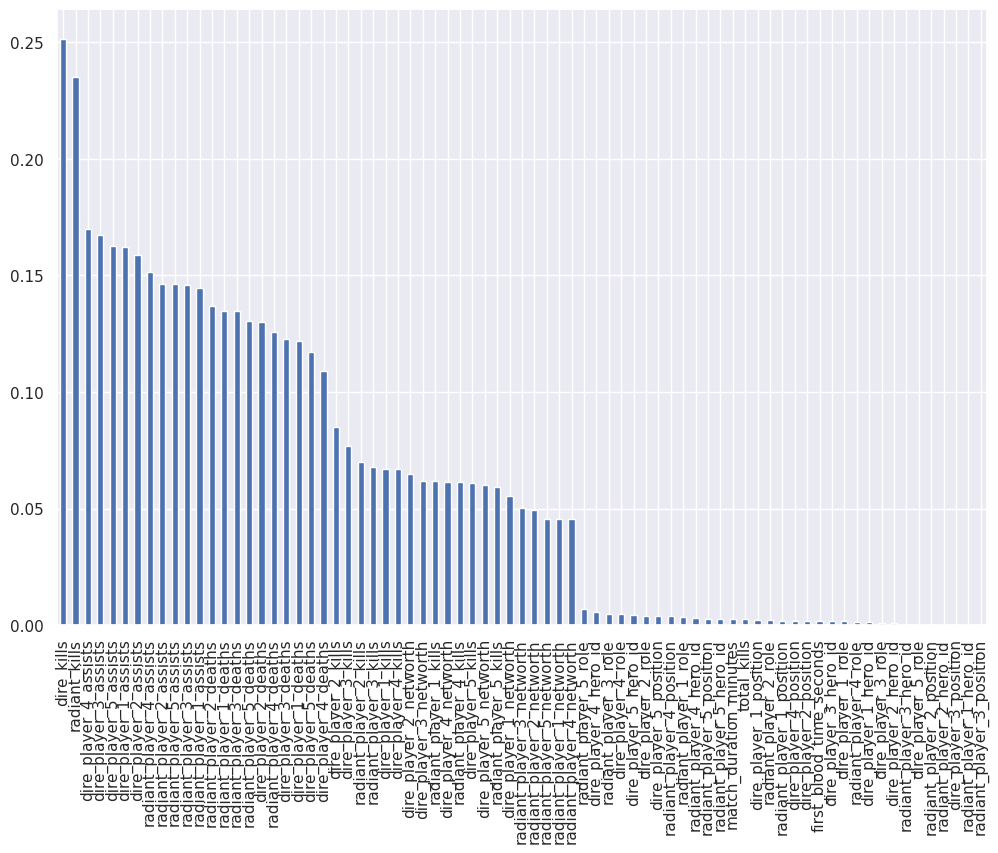

In [48]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(12,8))

In [49]:
# 10 heroes

# <20, 20-30, 30-40, 40-50, 50-60, >60

# 6 dfs




In [50]:
# dire_kill, rad_kill, kda/hero, nw/hero


In [51]:
sel_5_feats = SelectKBest(mutual_info_classif, k=25)
sel_5_feats.fit(X_train, y_train)

X_train.columns[sel_5_feats.get_support()]

Index(['radiant_kills', 'dire_kills', 'radiant_player_1_deaths',
       'radiant_player_1_assists', 'radiant_player_2_kills',
       'radiant_player_2_deaths', 'radiant_player_2_assists',
       'radiant_player_3_deaths', 'radiant_player_3_assists',
       'radiant_player_4_deaths', 'radiant_player_4_assists',
       'radiant_player_5_deaths', 'radiant_player_5_assists',
       'dire_player_1_deaths', 'dire_player_1_assists', 'dire_player_2_kills',
       'dire_player_2_deaths', 'dire_player_2_assists', 'dire_player_3_kills',
       'dire_player_3_deaths', 'dire_player_3_assists', 'dire_player_4_deaths',
       'dire_player_4_assists', 'dire_player_5_deaths',
       'dire_player_5_assists'],
      dtype='object')

## Dimensionality Reduction

Now that we have chosen top 25 features based on Information Gain, we can further reduce the dimensionality using *`Principal Component Analysis (PCA)`*

#### Standard Scaling

In [52]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### PCA

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(X_train_scaled)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#### Naive Bayes Classifier vs Linear Discriminant Analysis

In [92]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV


def print_results(model_name, results):
    print(f'BEST PARAMS FOR {model_name}: {results.best_params_}\n')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
    print()

def get_best_model(model_name, clf, params, cv=5):
    
    grid = GridSearchCV(clf, params, cv=cv)
    if model_name == 'GaussianNB':
        grid.fit(X_train_pca, y_train)
    else:
        grid.fit(X_train_scaled, y_train)
        
    print_results(model_name, grid)
    
    return grid.best_estimator_



def get_scores(models):
    
    for model_name in models:
        
        model = models[model_name]

        if model_name == 'GaussianNB':

            y_pred = model.predict(X_test_pca)
            y_pred_prob = model.predict_proba(X_test_pca)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
        else:
            y_pred = model.predict(X_test_scaled)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        
        roc_auc = auc(fpr, tpr)
        scores = {
            "accuracy":accuracy_score(y_test,y_pred),
            "precision":precision_score(y_test,y_pred),
            "recall":recall_score(y_test, y_pred),
            "f1_score":f1_score(y_test,y_pred),
            "roc_auc_score":roc_auc
        }
        print('-'*10 + f'{model_name}' + '-'*10)
        for score in scores:
            print(f'{score} : {scores[score]}')


        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')  
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    

In [93]:
models = {}
nb = GaussianNB()
lda = LinearDiscriminantAnalysis()
nb_params = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
lda_params = {
    'solver': ['lsqr'],
    'shrinkage': [None, 'auto']
}

models['GaussianNB'] = get_best_model('GaussianNB', nb, nb_params)
models['LDA'] = get_best_model('LDA', lda, lda_params)

BEST PARAMS FOR GaussianNB: {'var_smoothing': 1e-09}

0.95 (+/-0.004) for {'var_smoothing': 1e-09}
0.95 (+/-0.004) for {'var_smoothing': 1e-08}
0.95 (+/-0.004) for {'var_smoothing': 1e-07}

BEST PARAMS FOR LDA: {'shrinkage': 'auto', 'solver': 'lsqr'}

0.988 (+/-0.002) for {'shrinkage': None, 'solver': 'lsqr'}
0.988 (+/-0.002) for {'shrinkage': 'auto', 'solver': 'lsqr'}



----------GaussianNB----------
accuracy : 0.9493328176368208
precision : 0.9425770308123249
recall : 0.956707159472732
f1_score : 0.9495895330938944
roc_auc_score : 0.9882965845258584


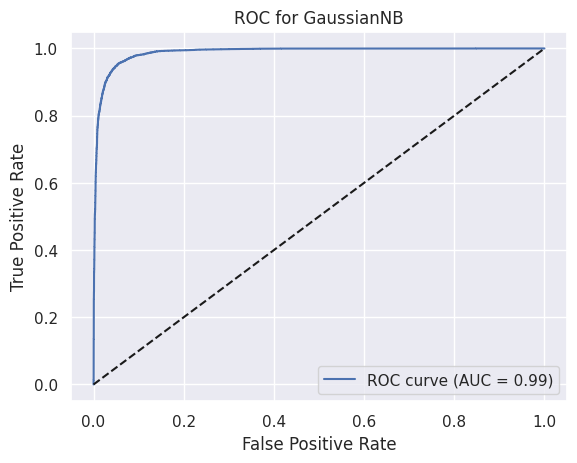

----------LDA----------
accuracy : 0.9883323664023722
precision : 0.9872340425531915
recall : 0.989402946497803
f1_score : 0.9883173045891693
roc_auc_score : 0.9883349137633709


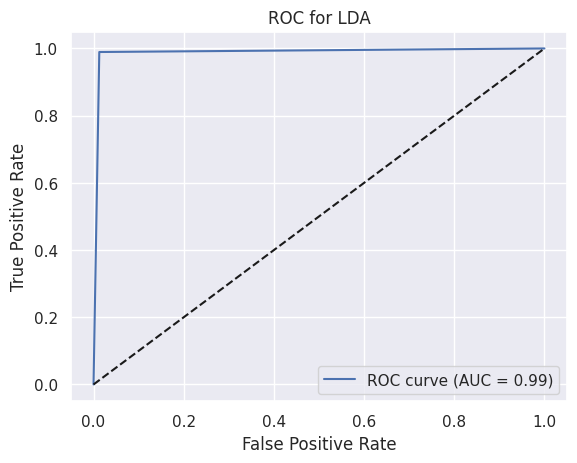

In [94]:
get_scores(models)

## Game outcome prediction at different time frames